In [3]:
from binance.client import Client
from binance import ThreadedWebsocketManager
import binance as bn
from binance.exceptions import BinanceAPIException
import requests as requests
import pandas as pd
import sys
from datetime import datetime, timedelta
import ta as ta
import numpy as np
import json
import sys
sys.path.append('C:\\Users\\Administrator\\Desktop\\utils')
import utils
import matplotlib.pyplot as plt
import smtplib
import time
import json
sys.path.append('C:\\Users\\Administrator\\Desktop\\data')
import tokyo_data

In [28]:
class Futures_trader():
    """
    Class to perform live testing using Binance Futures testnet stream of data
    """ 
    def __init__(self, api_key=None, api_secret=None, testnet=None, symbol=None, units='0.006', interval=None, ema_slow=None, ema_fast=None, ema_signal=None, sma_slow=None, sma_fast=None, sl=None, tp=None, leverage=2, bot_name='macd_sma', assigned_duration_minutes=None, assigned_emergency_price_chg_pu=None, emg_chg_type='both'):
        """
        :param symbol: ticker in Binance, i.e. "BTCUSDT"
        :type symbol: str.
        ----
        :param units: amount of base units, i.e. "BTC"
        :param type: float.
        ----
        :param interval: a string among the followings: ["1m", "3m", "5m", "15m", "30m", "1h", "2h", "4h", "6h", "8h", "12h", "1d", "3d", "1w", "1M"]
        :type interval: str.
        ----
        :param ema_slow: EMA slow for MACD calculation
        :type ema_slow: int.
        ----
        :param ema_fast: EMA fast for MACD calculation
        :type ema_fast: int.
        ----
        :param ema_signal: EMA signal for MACD calculation
        :type ema_signal: int.
        ----
        :param sma_slow: SMA slow signal for sma cross calculation
        :type sma_slow: int.
        ----        
        :param sma_fast: SMA fast signal for sma cross calculation
        :type sma_fast: int.
        ----            
        :param sl: per unit of closing price to execute stop loss
        :type sl: float
        ----
        :param tp: per unit of closing price to execute take profit
        :type tp: float
        ----
        :param leverage: leverage to use
        :type leverage: integer
        ----
        :param bot_name: name of the current strategy
        :type bot_name: string
        ---
        :param testnet: if True, testnet is used, otherwise REAL Binance account
        :type testnet: bool.
        ----
        :param assigned_duration_minutes: amount of minutes that the sesion is expected to last, if no problems appear.
        :type assigned_duration_minutes: int.
        ----
        :param: assigned_emergency_price_chg_pu: per unit threshold (in absolute value) above which a sell order will be executed for safety purposes.
        In the case of a price increase the pct is taken as double of the value introduced (ratio 2 win : 1 lose)
        :type assigned_emergency_price_chg_pu: float
        """
        self.api_key = api_key
        self.api_secret = api_secret
        self.units = units
        self.symbol = symbol
        self.interval = interval
        self.ema_slow = ema_slow
        self.ema_fast = ema_fast
        self.ema_signal = ema_signal 
        self.sma_slow = sma_slow
        self.sma_fast = sma_fast
        self.sl = sl
        self.tp = tp
        self.leverage = leverage
        self.bot_name = bot_name
        self.testnet = testnet 
        self.assigned_duration_minutes = assigned_duration_minutes
        self.run_end_time_utc = None #time in UTC when the calculation finished
        self.run_end_delta = None #amount of time that has passed since the beginning of the calculation
        self.data = pd.DataFrame() #initialized dataframe to contain all OHLC data
        self.orders = 0 #counter of the number of orders
        self.position = None #initially no position is decided, it is pending to analysis recent data of macd to decide if it is long (1), neutral (0) or no position ('np')
        self.client = Client(api_key=self.api_key, api_secret=self.api_secret, tld = "com", testnet = self.testnet)
        self.trade_start_time_utc = None # time in utc to be defined when the stream of OHLC starts ( this time
        self.twm = None # Initialize ws client
        self.cum_profits = 0 #accumulated profits in the trading sesion
        self.initialize_emergency_price_parameters(assigned_emergency_price_chg_pu)
        self.conn = None #smtp connection
        self.login_mail() #initialize smtp google account
        self.kline_tlast = None #date of latest kandle complete to use in define_strategy()
        self.emg_chg_type = None # 'up' for price increase algo, 'down' for price decrease algo, None for both deactivated, 'both' for both activated
        self.td = self.calculate_td() # initialize delta t depending on interval chosen
        self.keep_long = False # initialize flags for long position continuation
        self.keep_short = False # initialize flags for short position continuation
        self.orders_list = []
        self.trades_list = []
        self.position = 0
        self.pos_debug = []
    
    def calculate_td(self):
        td = timedelta()
        if 'm' in self.interval:
            num_min = int(self.interval.replace('m',''))
            td = timedelta(minutes=num_min)
        if 'h' in self.interval:
            num_h = int(self.interval.replace('h',''))
            td = timedelta(hours=num_h)
        if 'd' in self.interval:
            num_day = int(self.interval.replace('d',''))
            td = timedelta(days=num_day)
        if 'w' in self.interval:
            num_week = int(self.interval.replace('w',''))
            td = timedelta(weeks=num_week)
        if 'M' in self.interval:
            num_week_m = int(self.interval.replace('M',''))
            td = timedelta(weeks=4*num_week)
        return td 

    def start_trading(self):
        #self.client.futures_change_margin_type(symbol = "BTCUSDT", marginType = "CROSSED")
        self.trade_start_time_utc = datetime.utcnow()
        self.prepare_recent_data()
        self.stablish_initial_position()
        self.calculate_returns()
        
        try:
            print('try 1')
            self.client.futures_change_leverage(symbol = "BTCUSDT", leverage = self.leverage) #initialize leverage        
        except (BinanceAPIException, ConnectionResetError, requests.exceptions.ConnectionError, requests.exceptions.RequestException) as e:
            print('except 1')
            self.client = Client(api_key=self.api_key, api_secret=self.api_secret, tld = "com", testnet = self.testnet)
            self.client.futures_change_leverage(symbol = "BTCUSDT", leverage = self.leverage) #initialize leverage        
            
        self.init_socket()
        
    def init_socket(self):
        self.twm = ThreadedWebsocketManager()
        self.twm.start() 
        try: 
            print('try 2')
            self.twm.start_kline_futures_socket(callback = self.stream_candles, symbol = self.symbol, interval = self.interval)
        except (BinanceAPIException, ConnectionResetError, requests.exceptions.ConnectionError, requests.exceptions.RequestException) as e:
            print('except 2')
            print(e)
            print('Something went wrong. Error occured at %s. The sesions will be automatically stopped after GOING NEUTRAL.' % (datetime.now().astimezone(timezone.utc)))
            self.stop_ses()

    def stream_candles(self, msg):
        event_time = pd.to_datetime(msg["E"], unit = "ms")
        start_time = pd.to_datetime(msg["k"]["t"], unit = "ms")
        self.klast = start_time #latest kandle date, complete or incomplete
        self.kprev = start_time - self.td 
        first   = float(msg["k"]["o"])
        high    = float(msg["k"]["h"])
        low     = float(msg["k"]["l"])
        close   = float(msg["k"]["c"])
        volume  = float(msg["k"]["v"])
        complete=       msg["k"]["x"]
        # feed df (add new bar / update latest bar)
        self.data.loc[start_time, 'Open'] = first
        self.data.loc[start_time, 'High'] = high
        self.data.loc[start_time, 'Low'] = low
        self.data.loc[start_time, 'Close'] = close
        self.data.loc[start_time, 'Volume'] = volume
        self.data.loc[start_time, 'Complete'] = complete
        #update MACD parameters with each ws retrieval
        macd_diff = ta.trend.MACD(close=self.data.Close, window_slow=self.ema_slow, window_fast=self.ema_fast, window_sign=self.ema_signal, fillna=False).macd_diff()
        macd_macd = ta.trend.MACD(close=self.data.Close, window_slow=self.ema_slow, window_fast=self.ema_fast, window_sign=self.ema_signal, fillna=False).macd()
        macd_signal = ta.trend.MACD(close=self.data.Close, window_slow=self.ema_slow, window_fast=self.ema_fast, window_sign=self.ema_signal, fillna=False).macd_signal()         
        #assigning the macd values to ticker dataframe
        self.data.loc[start_time, 'macd_diff'] = macd_diff.iloc[-1]
        self.data.loc[start_time, 'macd_macd'] = macd_macd.iloc[-1]
        self.data.loc[start_time, 'macd_signal'] = macd_signal.iloc[-1]
        #update SMAs with each ws retrieval
        sma_fast_ps = ta.trend.SMAIndicator(close=self.data.Close, window=self.sma_fast, fillna=False).sma_indicator()
        sma_slow_ps = ta.trend.SMAIndicator(close=self.data.Close, window=self.sma_slow, fillna=False).sma_indicator()
        #assigning the smas values to ticker dataframe
        self.data.loc[start_time, 'sma_fast_ps'] = sma_fast_ps.iloc[-1]
        self.data.loc[start_time, 'sma_slow_ps'] = sma_slow_ps.iloc[-1]
        #initialize sltp_flag data to False
        self.data.loc[start_time, 'sl_flag_short'] = False
        self.data.loc[start_time, 'tp_flag_short'] = False
        self.data.loc[start_time, 'tp_flag_long'] = False
        self.data.loc[start_time, 'sl_flag_long'] = False 
        #initialize emergency position
        self.data.loc[start_time, 'emg_pos'] = False
        
        #print(f"event_time = {event_time}, start_time = {start_time}, complete = {complete}, sma_fast_ps = {sma_fast_ps.iloc[-1]}, sma_slow_ps = {sma_slow_ps.iloc[-1]}")
        print(".", end = "", flush = True) # just print something to get a feedback (everything OK)        
        
        dt = datetime.utcnow() - self.trade_start_time_utc
        if ((dt) > timedelta(minutes=self.assigned_duration_minutes)):
            self.stop_ses()        
        
        if (self.assigned_emergency_price_chg_pu != None):
            self.run_emergency_price_check(close) # position is forced by this method without needing to call update_position
        
        if (complete == True and self.emergency_price_chg_flag==False):
            self.update_position()
            self.execute_trades()
            self.calculate_returns()
        else:
            pass
            
    def initialize_emergency_price_parameters(self, assigned_emergency_price_chg_pu=None):
        self.assigned_emergency_price_chg_pu = assigned_emergency_price_chg_pu # positive threshold of returns to trigger emergency price change method
        self.close_pair = [] #two consecutive "close" prices to implement emergency price algorithm
        self.emergency_price_chg_flag = False #flag to activate the signal
        self.emergency_msg = None #message to be sent when emergency price signal activated
        self.pu_price_chg = None #percetatge of change in price monitored every second
        self.increase_counter = 0 #counter to monitor consecutive sharp increases in price per second
        self.decrease_counter = 0 #counter to monitor consecutive sharp decreases in price per second       

    def run_emergency_price_check(self, close=None):
        if (len(self.close_pair) == 0):
            self.close_pair.append(close)
            return # there are not yet 2 values in the array to start the algo (self.pu_chg_flag is still "None")
        
        if (self.emg_chg_type != 'None'):
            if (len(self.close_pair) == 1):
                self.close_pair.insert(0,close)
                self.pu_price_chg = ((self.close_pair[1]/self.close_pair[0])-1)
            elif (len(self.close_pair) == 2):
                self.close_pair.pop()
                self.close_pair.insert(0,close)
                self.pu_price_chg = ((self.close_pair[1]/self.close_pair[0])-1)
                # condition for emergency price increase
                if (self.emg_chg_type == 'up' or self.emg_chg_type == 'both'):
                    if (self.pu_price_chg > 2 * self.assigned_emergency_price_chg_pu):
                        self.emergency_price_chg_flag = True
                        self.decrease_counter = 0
                        self.increase_counter += 1
                        self.emergency_msg = f"PRICE CHANGE - INCREASE - {self.increase_counter}"
        #                 print(self.emergency_msg)
                        if (self.increase_counter < 3):
                            pass
                        elif (self.increase_counter == 3):
                            self.emergency_position_eval_increase()                               
                            self.emergency_price_chg_flag = False
                            self.increase_counter = 0
                            self.end_socket()
                            time.sleep(45)
                            self.init_socket()
                        else:
                            pass

                if (self.emg_chg_type == 'down' or self.emg_chg_type == 'both'):   
                # condition for emergency price decrease                    
                    if (self.pu_price_chg < -1*self.assigned_emergency_price_chg_pu):
                        self.emergency_price_chg_flag = True
                        self.increase_counter = 0
                        self.decrease_counter += 1
                        self.emergency_msg = f"PRICE CHANGE - DECREASE - {self.decrease_counter}"
        #                 print(self.emergency_msg)                
                        if (self.decrease_counter < 3):
                            pass
                        elif (self.decrease_counter == 3):
                            self.emergency_position_eval_decrease()
                            self.emergency_price_chg_flag = False
                            self.decrease_counter = 0
                            self.end_socket()
                            time.sleep(45)
                            self.init_socket()
                        else:
                            pass
                    # condition for no emergency price change        
                    else:
                        self.emergency_price_chg_flag = False
                        self.increase_counter = 0
                    self.decrease_counter = 0  
            else:
                raise Exception(f"len(self.close_pair)={len(self.close_pair)} --- Unexpected value")     
        
    def prepare_recent_data(self):
        '''
        :param start: a string with the following format ""%Y-%m-%d-%H:%M" .i.e. "2022-01-29-20:00"
        :type start: str.
        :param end: a string with the following format ""%Y-%m-%d-%H:%M" .i.e. "2022-02-29-20:00"
        :type end: str.
        '''
        #Prepare pre-data to the present moment with non NaN for the trading period (macd paramters ready)
        #no utc time (Japan time) has to be used in futures_history
        current_time_obj = datetime.now()
        current_time = int(current_time_obj.timestamp()*1000)
        
        #["1m", "3m", "5m", "15m", "30m", "1h", "2h", "4h", "6h", "8h", "12h", "1d", "3d", "1w", "1M"]
        extra_periods = 0
        ema_diff = self.ema_slow + self.ema_signal + 2
        
        # Necessary extra periods to have enough data to calculate the strategy parameters at the present moment
        if (ema_diff >= self.sma_slow):
            extra_periods = ema_diff * 2
        else:
            extra_periods = self.sma_slow * 2
            
        td = timedelta()
        if 'm' in self.interval:
            num_min = int(self.interval.replace('m',''))
            td = timedelta(minutes=num_min*(extra_periods))
        if 'h' in self.interval:
            num_h = int(self.interval.replace('h',''))
            td = timedelta(hours=num_h*(extra_periods))
        if 'd' in self.interval:
            num_day = int(self.interval.replace('d',''))
            td = timedelta(days=num_day*(extra_periods))
        if 'w' in self.interval:
            num_week = int(self.interval.replace('w',''))
            td = timedelta(weeks=num_week*(extra_periods))
        if 'M' in self.interval:
            num_week_m = int(self.interval.replace('M',''))
            td = timedelta(weeks=num_week_m * 4 * (extra_periods))

        from_time_obj = current_time_obj - td
        from_time = int((current_time_obj - td).timestamp()*1000)
        self.data = utils.futures_history(symbol=self.symbol, interval=self.interval, start=from_time, end=current_time, testnet=self.testnet)
        #obtaining MACD instance from python ta
        macd_diff = ta.trend.MACD(close=self.data.Close, window_slow=self.ema_slow, window_fast=self.ema_fast, window_sign=self.ema_signal, fillna=False).macd_diff()
        macd_macd = ta.trend.MACD(close=self.data.Close, window_slow=self.ema_slow, window_fast=self.ema_fast, window_sign=self.ema_signal, fillna=False).macd()
        macd_signal = ta.trend.MACD(close=self.data.Close, window_slow=self.ema_slow, window_fast=self.ema_fast, window_sign=self.ema_signal, fillna=False).macd_signal()
        #assigning the values of macd to ticker dataframe
        self.data['macd_diff'] = macd_diff
        self.data['macd_macd'] = macd_macd
        self.data['macd_signal'] = macd_signal
        #calculating SMA fast and slow
        sma_fast_ps = ta.trend.SMAIndicator(close=self.data.Close, window=self.sma_fast, fillna=False).sma_indicator()
        sma_slow_ps = ta.trend.SMAIndicator(close=self.data.Close, window=self.sma_slow, fillna=False).sma_indicator()
        #assigning the smas values to ticker dataframe
        self.data['sma_fast_ps'] = sma_fast_ps
        self.data['sma_slow_ps'] = sma_slow_ps
        #initialize dataframe columns for prepared data
        self.data['position'] = 0
        self.data['macd_inv_sign'] = 0
        self.data['sma_conf'] = 0
        self.data['sma_inv_sign'] = 0
        self.data['macd_diff_conf'] = 0
        if (self.sl != None and self.tp != None):
            self.data['sl_flag_short'] = False
            self.data['tp_flag_short'] = False
            self.data['sl_flag_long'] = False
            self.data['tp_flag_long'] = False
        else: 
            pass
        self.data["Complete"] = [True for row in range(len(self.data)-1)] + [False]
        #decide position to be given to the latest recent data kandle (not completed in 99% of cases and that is 
        #going to be updated by the stream of data, so actually, position given to the latest kandle at this point
        #it is mots likely not to be used, but updated.
    
    def stablish_initial_position(self):
        # for avoiding unnecessary NaN values, initialize emg_pos
        self.data['emg_pos'] = False
        
        # --------------------- MACD CROSS SIGNAL + SMA CONFIRMATION ---------------------

        #macd cross short
        ht_macd_diff_pos = self.data.macd_diff.shift(1) > 0
        ht_macd_diff_plusone_neg = self.data.macd_diff < 0        
       
        #sma short confirmation
        sma_conf_short = self.data.sma_fast_ps < self.data.sma_slow_ps
        
        #stablish short positions
        self.data.loc[ht_macd_diff_pos & ht_macd_diff_plusone_neg, 'macd_inv_sign'] = -1
        self.data.loc[sma_conf_short, 'sma_conf'] = -1
        
        #macd cross long
        ht_macd_diff_neg = self.data.macd_diff.shift(1) < 0
        ht_macd_diff_plusone_pos = self.data.macd_diff > 0
        
        #sma long confirmation
        sma_conf_long = self.data.sma_fast_ps > self.data.sma_slow_ps        
        
        #stablish buy positions
        self.data.loc[ht_macd_diff_neg & ht_macd_diff_plusone_pos, 'macd_inv_sign'] = 1
        self.data.loc[sma_conf_long, 'sma_conf'] = 1
        
        # ---------------------------------------------------------------------------------
        
        # --------------------- SMA CROSS SIGNAL + MACD_DIFF CONFIRMATION -----------------
        
        #sma cross short
        ht_sma_pos = self.data.sma_fast_ps.shift(1) > self.data.sma_slow_ps.shift(1)
        ht_sma_plusone_neg = self.data.sma_fast_ps < self.data.sma_slow_ps
        
        #macd_diff short confirmation
        macd_diff_conf_short = self.data.macd_diff < 0
        
        #stablish short positions
        self.data.loc[ht_sma_pos & ht_sma_plusone_neg, 'sma_inv_sign'] = -1
        self.data.loc[macd_diff_conf_short, 'macd_diff_conf'] = -1
        
        #sma cross long
        ht_sma_neg = self.data.sma_fast_ps.shift(1) < self.data.sma_slow_ps.shift(1)
        ht_sma_plusone_pos = self.data.sma_fast_ps > self.data.sma_slow_ps        
        
        #macd_diff long confirmation
        macd_diff_conf_long = self.data.macd_diff > 0
        
        #stablish buy positions
        self.data.loc[ht_sma_neg & ht_sma_plusone_pos, 'sma_inv_sign'] = 1
        self.data.loc[macd_diff_conf_long, 'macd_diff_conf'] = 1        
        
        # ---------------------------------------------------------------------------------
        for index, data in self.data.iterrows():
            
            condlong1 = ((data.macd_inv_sign == 1 and data.sma_inv_sign == 1) or (data.macd_inv_sign == 1 and data.sma_conf == 1))
            condshort1 = ((data.macd_inv_sign == -1 and data.sma_inv_sign == -1) or (data.macd_inv_sign == -1 and data.sma_conf == -1))
            condlong2 = ((data.sma_inv_sign == 1 and data.macd_inv_sign == 1) or (data.sma_inv_sign == 1 and data.macd_diff_conf == 1))
            condshort2 = ((data.sma_inv_sign == -1 and data.macd_inv_sign == -1) or (data.sma_inv_sign == -1 and data.macd_diff_conf == -1))
            
            if (condlong1 == True and condshort1 == False and condlong2 == False and condshort2 == False):
                self.data.loc[index, 'position'] = 1
                one_delta_pos = index + (self.data.index[1]-self.data.index[0])
                self.data_sub_buy = self.data.loc[one_delta_pos:]
                for index_sub_buy, data_sub_buy in self.data_sub_buy.iterrows():
                    condsubshort1 = ((data_sub_buy.macd_inv_sign == -1 and data_sub_buy.sma_inv_sign == -1) or (data_sub_buy.macd_inv_sign == -1 and data_sub_buy.sma_conf == -1))
                    condsubshort2 = ((data_sub_buy.sma_inv_sign == -1 and data_sub_buy.macd_inv_sign == -1) or (data_sub_buy.sma_inv_sign == -1 and data_sub_buy.macd_diff_conf == -1))                                                       
                    if (condsubshort1 == True or condsubshort2 == True):
                        break
                    else: 
                        self.data.loc[index_sub_buy, 'position'] = 1
                
            elif (condlong1 == False and condshort1 == True and condlong2 == False and condshort2 == False): 
                self.data.loc[index, 'position'] = -1
                one_delta_pos = index + (self.data.index[1]-self.data.index[0])
                self.data_sub_sell = self.data.loc[one_delta_pos:]
                for index_sub_sell, data_sub_sell in self.data_sub_sell.iterrows():
                    condsublong1 = ((data_sub_sell.macd_inv_sign == 1 and data_sub_sell.sma_inv_sign == 1) or (data_sub_sell.macd_inv_sign == 1 and data_sub_sell.sma_conf == 1))
                    condsublong2 = ((data_sub_sell.sma_inv_sign == 1 and data_sub_sell.macd_inv_sign == 1) or (data_sub_sell.sma_inv_sign == 1 and data_sub_sell.macd_diff_conf == 1))                    
                    if (condsublong1 == True or condsublong2 == True):
                        break
                    else:
                        self.data.loc[index_sub_sell, 'position'] = -1
                        
            elif (condlong1 == False and condshort1 == False and condlong2 == True and condshort2 == False):
                self.data.loc[index, 'position'] = 1
                one_delta_pos = index + (self.data.index[1]-self.data.index[0])
                self.data_sub_buy = self.data.loc[one_delta_pos:]
                for index_sub_buy, data_sub_buy in self.data_sub_buy.iterrows():
                    condsubshort1 = ((data_sub_buy.macd_inv_sign == -1 and data_sub_buy.sma_inv_sign == -1) or (data_sub_buy.macd_inv_sign == -1 and data_sub_buy.sma_conf == -1))
                    condsubshort2 = ((data_sub_buy.sma_inv_sign == -1 and data_sub_buy.macd_inv_sign == -1) or (data_sub_buy.sma_inv_sign == -1 and data_sub_buy.macd_diff_conf == -1))                      
                    if (condsubshort1 == True or condsubshort2 == True):
                        break
                    else:
                        self.data.loc[index_sub_buy, 'position'] = 1
                
            elif (condlong1 == False and condshort1 == False and condlong2 == False and condshort2 == True):
                self.data.loc[index, 'position'] = -1
                one_delta_pos = index + (self.data.index[1]-self.data.index[0])
                self.data_sub_sell = self.data.loc[one_delta_pos:]
                for index_sub_sell, data_sub_sell in self.data_sub_sell.iterrows():
                    condsublong1 = ((data_sub_sell.macd_inv_sign == 1 and data_sub_sell.sma_inv_sign == 1) or (data_sub_sell.macd_inv_sign == 1 and data_sub_sell.sma_conf == 1))
                    condsublong2 = ((data_sub_sell.sma_inv_sign == 1 and data_sub_sell.macd_inv_sign == 1) or (data_sub_sell.sma_inv_sign == 1 and data_sub_sell.macd_diff_conf == 1))                    
                    if (condsublong1 == True or condsublong2 == True):
                        break
                    else:
                        self.data.loc[index_sub_sell, 'position'] = -1 
            else:
                pass
        self.position = 0
        self.kprev = self.data.index[-2]
    
    def calculate_returns(self):
        #stablish the trading costs and the number of trades done
        data = self.data.loc[self.trade_start_time_utc:].copy()

        data['trades'] = 0
        trading_cost_fees = 0.0004
        trading_cost_others = 0.00001
        trading_cost = np.log(1 - trading_cost_fees) + np.log(1 - trading_cost_others)
        trade_exec_cond = data.position.diff().fillna(0).abs() != 0
        data.loc[trade_exec_cond, 'trades'] = 1
        total_trades = data.trades[data.trades == 1].sum()
        #calculate strategy returns
        data['log_returns_hold'] = np.log(data.Close.div(data.Close.shift(1)))
        data['multiple_hold_acum'] = np.exp(data.log_returns_hold.cumsum())
        data['macd_log_returns'] = data.log_returns_hold * data.position.shift(1)
        data['macd_log_returns_net'] = data.macd_log_returns + data.trades * trading_cost
        data['macd_multiple_acum'] = np.exp(data.macd_log_returns.cumsum())
        data['macd_multiple_net_acum'] = np.exp(data.macd_log_returns_net.cumsum())
        #calculating profitable trades with trading costs
        cond_profit_net1 = data.trades == 1
        cond_profit_net2 = ((data.Close.div(data.Close.shift(-1)) - 1) + np.log(1 - 0.0004) + np.log(1 - 0.0001))  > 0
        success_trades_net = data[cond_profit_net1&cond_profit_net2].trades.sum()
        if (total_trades != 0):
            success_trades_net_pct = round((success_trades_net / total_trades)*100,1)
        #calculating failure trades with trading costs
        cond_failure_net1 = data.trades == 1
        cond_failure_net2 = ((data.Close.div(data.Close.shift(-1)) - 1) + np.log(1 - 0.00075) + np.log(1 - 0.0001))  < 0
        failure_trades_net = data[cond_failure_net1&cond_failure_net2].trades.sum()
        if (total_trades != 0):
            failure_trades_net_pct = round((failure_trades_net / total_trades)*100, 1)
        # Adds/Labels Trading Sessions and their compound returns.
        data["ses"] = np.sign(data.trades).cumsum().shift().fillna(0)
        data["macd_simplecret_net_ses"] = data.groupby("ses").macd_log_returns_net.cumsum().apply(np.exp) - 1        
        data["macd_simple_ret"] = np.exp(data.macd_log_returns_net) - 1
        data["eff_lev"] = self.leverage * (1 + data.macd_simplecret_net_ses) / (1 + data.macd_simplecret_net_ses * self.leverage)
        data.eff_lev.fillna(self.leverage, inplace = True)
        levered_returns = data.eff_lev.shift() * data.macd_simple_ret
        levered_returns = np.where(levered_returns < -1, -1, levered_returns)
        data["macd_simple_ret_net_lev"] = levered_returns
        data["macd_simple_ret_net_lev_acum"] = data.macd_simple_ret_net_lev.add(1).cumprod()
        
        self.data["macd_simple_ret_net_lev_acum"] = data["macd_simple_ret_net_lev_acum"]
        self.data['multiple_hold_acum'] = data['multiple_hold_acum']
        self.data['macd_multiple_net_acum'] = data['macd_multiple_net_acum']
        
        
               
    def run_sltp_check(self, data=None):
        
        klast = self.klast
        kprev = self.kprev         
        tp_flag_short = self.data.Close.loc[klast] <= (self.data.Close.loc[kprev] * (1 - self.tp)) # condition for stop loss in short position ### ERROR HERE WHILE STREAMING
        sl_flag_short = self.data.Close.loc[klast] > (self.data.Close.loc[kprev] * (1 + self.sl)) # condition for take profit in short position       
        tp_flag_long = self.data.Close.loc[klast] >= (self.data.Close.loc[kprev] * (1 + self.tp)) # condition for stop loss in long position
        sl_flag_long = self.data.Close.loc[klast] < (self.data.Close.loc[kprev] * (1 - self.sl)) # condition for take profit in long position          
        
        if (self.data.position.loc[kprev] == -1):
            if (tp_flag_short):
                self.data.loc[klast, 'tp_flag_short'] = True               
                self.data.loc[klast, 'position'] = 0
                return True
            elif sl_flag_short:
                self.data.loc[klast, 'sl_flag_short'] = True                 
                self.data.loc[klast, 'position'] = 0
                return True
            else:
                 pass
             
        elif (self.data.position.loc[kprev] == 1):
            if (tp_flag_long):
                self.data.loc[klast, 'tp_flag_long'] = True           
                self.data.loc[klast, 'position'] = 0
                return True
            elif sl_flag_long:
                self.data.loc[klast, 'sl_flag_long'] = True                 
                self.data.loc[klast, 'position'] = 0
                return True
            else:
                pass
                
        elif (self.data.position.loc[kprev] == 0):
            pass
        
        else:
            raise Exception(f"(self.data.position.loc[kprev] = {self.data.position.loc[kprev]}) --- Unexpected value")
        
        self.data = self.data.copy()
        return False
    
    def update_position(self):
        klast = self.klast #
        kprev = self.kprev #
                
        # --------------------- MACD CROSS SIGNAL + SMA CONFIRMATION ---------------------
        
        #macd cross long
        ht_macd_diff_neg = self.data.macd_diff.loc[kprev] < 0 #
        ht_macd_diff_plusone_pos = self.data.macd_diff.loc[klast] > 0 #   
        #macd cross short
        ht_macd_diff_pos = self.data.macd_diff.loc[kprev] > 0 #
        ht_macd_diff_plusone_neg = self.data.macd_diff.loc[klast] < 0 #
    
        if (ht_macd_diff_neg and ht_macd_diff_plusone_pos): #
            self.data.loc[klast, 'macd_inv_sign'] = 1 #
        elif (ht_macd_diff_pos and ht_macd_diff_plusone_neg): #
            self.data.loc[klast, 'macd_inv_sign'] = -1 #
        else: #
            self.data.loc[klast, 'macd_inv_sign'] = 0 #
        
        #sma long confirmation
        sma_conf_long = self.data.sma_fast_ps.loc[klast] > self.data.sma_slow_ps.loc[klast] #
        #sma short confirmation
        sma_conf_short = self.data.sma_fast_ps.loc[klast] < self.data.sma_slow_ps.loc[klast] #
        if sma_conf_long: #
            self.data.loc[klast, 'sma_conf'] = 1 #
        elif sma_conf_short: #
            self.data.loc[klast, 'sma_conf'] = -1 #
        else: #
            self.data.loc[klast, 'sma_conf'] = 0 #
        
        # ---------------------------------------------------------------------------------
        
        # --------------------- SMA CROSS SIGNAL + MACD_DIFF CONFIRMATION -----------------

        #sma cross long
        ht_sma_neg = self.data.sma_fast_ps.loc[kprev] < self.data.sma_slow_ps.loc[kprev] #
        ht_sma_plusone_pos = self.data.sma_fast_ps.loc[klast] > self.data.sma_slow_ps.loc[klast] #        
        #sma cross short
        ht_sma_pos = self.data.sma_fast_ps.loc[kprev] > self.data.sma_slow_ps.loc[kprev] #
        ht_sma_plusone_neg = self.data.sma_fast_ps.loc[klast] < self.data.sma_slow_ps.loc[klast] #
                                                                                        
        if (ht_sma_neg and ht_sma_plusone_pos): #
            self.data.loc[klast, 'sma_inv_sign'] = 1 #
        elif (ht_sma_pos and ht_sma_plusone_neg):
            self.data.loc[klast, 'sma_inv_sign'] = -1 #
        else: #
            self.data.loc[klast, 'sma_inv_sign'] = 0 #
                                                                                    

        #macd_diff short confirmation
        macd_diff_conf_short = self.data.loc[klast, 'macd_diff'] < 0 #
        #macd_diff long confirmation
        macd_diff_conf_long = self.data.loc[klast, 'macd_diff'] > 0 #
                                                                                        
        if macd_diff_conf_long: #
            self.data.loc[klast, 'macd_diff_conf'] = 1 #
        elif macd_diff_conf_short: #
            self.data.loc[klast, 'macd_diff_conf'] = -1 #
        else:
            self.data.loc[klast, 'macd_diff_conf'] = 0 #
        
        # -------------------------------- POSITION DEFINITION -----------------------------
        condlong1 = ((self.data.loc[klast, 'macd_inv_sign'] == 1 and self.data.loc[klast, 'sma_inv_sign'] == 1) or (self.data.loc[klast, 'macd_inv_sign'] == 1 and self.data.loc[klast, 'sma_conf'] == 1))
        condshort1 = ((self.data.loc[klast, 'macd_inv_sign'] == -1 and self.data.loc[klast, 'sma_inv_sign'] == -1) or (self.data.loc[klast, 'macd_inv_sign'] == -1 and self.data.loc[klast, 'sma_conf'] == -1))
        condlong2 = ((self.data.loc[klast, 'sma_inv_sign'] == 1 and self.data.loc[klast, 'macd_inv_sign'] == 1) or (self.data.loc[klast, 'sma_inv_sign'] == 1 and self.data.loc[klast, 'macd_diff_conf'] == 1))
        condshort2 = ((self.data.loc[klast, 'sma_inv_sign'] == -1 and self.data.loc[klast, 'macd_inv_sign'] == -1) or (self.data.loc[klast, 'sma_inv_sign'] == -1 and self.data.loc[klast, 'macd_diff_conf'] == -1))
        
        if (condlong1 == True or condlong2 == True and condshort1 == False and condshort2 == False):
            self.data.loc[klast, 'position'] = 1
            
        elif (condshort1 == True or condshort2 == True and condlong1 == False and condlong2 == False):
            self.data.loc[klast, 'position'] = -1        
        
        elif (condlong1 == False and condshort1 == False and condlong2 == False and condshort2 == False):
            if (self.data.loc[kprev, 'position'] == 1):
                self.data.loc[klast, 'position'] = 1
            elif (self.data.loc[kprev, 'position'] == -1):
                self.data.loc[klast, 'position'] = -1
            else:
                self.data.loc[klast, 'position'] = 0      
        else:    
            raise Exception(f"Unexpected branch assessment in update_position() method at time={klast}")
        
        # if stltp signal, overwrite the position accordingly
        self.calculate_returns()    
        
        if (self.sl != None and self.tp != None):
            sltp_is_found = self.run_sltp_check(data=self.data)
            if (sltp_is_found):
                return
            else:
                pass         
    
    def execute_trades(self): 

        if self.data["position"].iloc[-1] == 1: # if position is long -> go/stay long
            if self.position == 0:
                order = self.client.futures_create_order(symbol = self.symbol, side = "BUY", type = "MARKET", quantity = self.units)
                self.assess_order_status(order, "GOING LONG")  
            elif self.position == -1:
                order = self.client.futures_create_order(symbol = self.symbol, side = "BUY", type = "MARKET", quantity = 2 * float(self.units))
                self.assess_order_status(order, "GOING LONG")
            self.position = 1
        elif self.data["position"].iloc[-1] == 0: # if position is neutral -> go/stay neutral
            if self.position == 1:
                order = self.client.futures_create_order(symbol = self.symbol, side = "SELL", type = "MARKET", quantity = self.units)
                self.assess_order_status(order, "GOING NEUTRAL") 
            elif self.position == -1:
                order = self.client.futures_create_order(symbol = self.symbol, side = "BUY", type = "MARKET", quantity = self.units)
                self.assess_order_status(order, "GOING NEUTRAL")
            self.position = 0
        if self.data["position"].iloc[-1] == -1: # if position is short -> go/stay short
            if self.position == 0:
                order = self.client.futures_create_order(symbol = self.symbol, side = "SELL", type = "MARKET", quantity = self.units)
                self.assess_order_status(order, "GOING SHORT") 
            elif self.position == 1:
                order = self.client.futures_create_order(symbol = self.symbol, side = "SELL", type = "MARKET", quantity = 2 * float(self.units))
                self.assess_order_status(order, "GOING SHORT")
            self.position = -1  

    def info_orders(self):
        pass
    
       
    def assess_order_status(self, order=None, GOING=None):
        print('executing assess_order_status')
        time.sleep(0.1) #ensure that the order is created and that is going to be found
        try:  
            print('try 3')
            order_details = self.client.futures_get_order(symbol = "BTCUSDT", orderId = order["orderId"]) # check order status
            print(order_details)
            self.orders_list.append(order_details)           
        except (BinanceAPIException, ConnectionResetError, requests.exceptions.ConnectionError, requests.exceptions.RequestException) as e:          
            print('except 3')
            self.client = Client(api_key=self.api_key, api_secret=self.api_secret, tld = "com", testnet = self.testnet)
            order_details = self.client.futures_get_order(symbol = "BTCUSDT", orderId = order["orderId"]) # check order status
            print(order_details)
            self.orders_list.append(order_details)         
        if (order_details['status'] == 'FILLED'):
            print('FILLED AND REPORTING...')
            self.report_trade(order, GOING) 
        else:
            print(f"order={order}", 'NOT FILLED AND NO NEED TO REPORT')           
    
    def report_trade(self, order, going):
        self.orders += 1
        order_time = order["updateTime"]
        try:
            print('try 4')
            trades = self.client.futures_account_trades(symbol = self.symbol, startTime = order_time)
        except (BinanceAPIException, ConnectionResetError, requests.exceptions.ConnectionError, requests.exceptions.RequestException) as e:            
            print('except 4')
            self.client = Client(api_key=self.api_key, api_secret=self.api_secret, tld = "com", testnet = self.testnet)
            trades = self.client.futures_account_trades(symbol = self.symbol, startTime = order_time)
        
        order_time = pd.to_datetime(order_time, unit = "ms")
        self.trades_list.append(trades)
        # extract data from order object
        df = pd.DataFrame(trades)
        columns = ["qty", "quoteQty", "commission","realizedPnl"]
        for column in columns:
            df[column] = pd.to_numeric(df[column], errors = "coerce")
        base_units = round(df.qty.sum(), 5)
        quote_units = round(df.quoteQty.sum(), 5)
        commission = -round(df.commission.sum(), 5)
        real_profit = round(df.realizedPnl.sum(), 5)
        price = round(quote_units / base_units, 5)
        
        # calculate cumulative trading profits
        self.cum_profits += round((commission + real_profit), 5)    
                 
        # print trade report
        print(2 * "\n" + 100* "-")
        msg1 = "{} | {}".format(order_time, going)
        print(msg1) 
        msg2 = "{} | Base_Units = {} | Quote_Units = {} | Price = {} ".format(order_time, base_units, quote_units, price)
        print(msg2)
        msg3 = "{} | net lev acum. = {} | net no lev acum. = {} | hold = {} ".format(order_time, self.data.loc[self.klast, 'macd_simple_ret_net_lev_acum'], self.data.loc[self.klast, 'macd_multiple_net_acum'], self.data.loc[self.klast, 'multiple_hold_acum'])
        print(msg3)
        msg4 = ""

        if (self.emergency_price_chg_flag == True):
            msg4 = "price changed in 1s in pct: {}, which is more/less than the imposed pct: {} (imposed pct x2 if positive) ".format(round(self.pu_price_chg, 6), self.assigned_emergency_price_chg_pu) 
            print(msg4)
        print(100 * "-" + "\n")
        mail_msg = f"Subject: trade executed. Bot name: {self.bot_name}. \n\n {msg1} \n\n {msg2} \n\n {msg3} \n\n {msg4}"
        try:
            print('try 5')
            self.conn.sendmail('jpxcar6@gmail.com', 'jpxcar6@gmail.com', f"{mail_msg}")

        except (smtplib.SMTPSenderRefused, smtplib.SMTPException, smtplib.SMTPServerDisconnected, smtplib.SMTPResponseException) as e:
            print('except 5')
            print(e)
            self.login_mail()
            self.conn.sendmail('jpxcar6@gmail.com', 'jpxcar6@gmail.com', f"{mail_msg}")

    def emergency_position_eval_increase(self):
        print('executing emergency_position_eval_increase')
        # stablish long position before kandle is complete. Handle the position logic in execute_trades()
        klast = self.klast
        self.data.loc[klast, 'position'] = 1
        self.calculate_returns()
        self.data.loc[klast, 'emg_pos'] = True
        self.execute_trades()
            
    def emergency_position_eval_decrease(self):
        print('executing emergency_position_eval_decrease')
        # stablish short position before kandle is complete. Handle the position logic in execute_trades()
        klast = self.klast
        self.data.loc[klast, 'position'] = 0
        self.calculate_returns()
        self.data.loc[klast, 'emg_pos'] = True
        self.execute_trades()

    def end_socket(self):
        self.twm.stop()
    
    def stop_ses(self, save_to_file=True):
        self.run_end_time_utc = datetime.utcnow()
        dt = self.run_end_time_utc - self.trade_start_time_utc
        self.run_end_delta = round(dt.seconds/60,0)
        print(f"trading sesion duration = {self.run_end_delta} minutes up to {self.assigned_duration_minutes}")
                            
        # stablish neutral position before kandle is complete. Handle the position logic in execute_trades()
        klast = self.klast
        self.data.loc[klast, 'position'] = 0
        self.calculate_returns()
        if (self.orders != 0):
            self.execute_trades()
        else:
            pass
        print('SESION STOPPED')
        self.twm.stop()
        
        if (save_to_file == True):
            self.save_to_files()

    def plot_results(self, start_plot=None, end_plot=None, width_bars=0.1):
        # from IPython.core.display import display, HTML
        # display(HTML("<style>.container { width:100% !important; }</style>"))
        colors=[]

        fig, (close_ax, macd_ax, acum_ax) = plt.subplots(nrows=3, ncols=1, figsize=(30,20), sharex=True)

        close_ax.grid(visible=True, which='major', axis='x', color='grey')
        macd_ax.grid(visible=True, which='major', axis='x', color='grey')
        close_ax.grid(visible=True, which='major', axis='y', color='grey')
        macd_ax.grid(visible=True, which='major', axis='y', color='grey')
        close_ax.grid(visible=True, which='minor', axis='x', color='grey')
        macd_ax.grid(visible=True, which='minor', axis='x', color='grey')

        close_ax.tick_params(labelrotation=45, labelsize = 'large')
        macd_ax.tick_params(labelrotation=45, labelsize = 'large')

        close_ax.margins(0)
        macd_ax.margins(0)
        
        close_ax.set_ylim(auto=True)
        
        data_ready = self.data.dropna(subset=['macd_diff', 'macd_macd', 'macd_signal', 'sma_fast_ps', 'sma_slow_ps', 'multiple_hold_acum', 'macd_simple_ret_net_lev_acum', 'macd_multiple_net_acum']).copy()
        
        
        if (start_plot == None):
            start_plot = data_ready.index[0]
        if (end_plot == None):
            end_plot = data_ready.index[-1]  
            
        if ((start_plot != None) and (end_plot !=None)):
            cond_start = data_ready.index >= start_plot
            cond_end = data_ready.index <= end_plot
            data_ready = data_ready[cond_start&cond_end]
                
        for index, value in data_ready.macd_diff.iteritems():
            if value > 0:
                colors.append('g')
            else:
                colors.append('r')
                
        close_ax.plot(data_ready.index, data_ready.Close) #plot the data without shifting
        close_ax.plot(data_ready.index, data_ready.sma_fast_ps)
        close_ax.plot(data_ready.index, data_ready.sma_slow_ps)
        close_ax.legend(['Close', 'sma_fast_ps', 'sma_slow_ps'])
        
        #shift one position the inv_sign only for plotting the signal in the day after is found, without shifting the
        #Close prices
        
        long_pos = data_ready.position == 1              
        long_trade = data_ready.loc[long_pos]
        short_pos = data_ready.position == -1            
        short_trade = data_ready.loc[short_pos]
        neutral_pos = data_ready.position == 0           
        neutral_trade = data_ready.loc[neutral_pos]        
        close_ax.scatter(short_trade.index, short_trade.Close.loc[short_trade.index], marker='^', color='r', s=100)
        close_ax.scatter(long_trade.index, long_trade.Close.loc[long_trade.index], marker='^', color='g', s=100)
        close_ax.scatter(neutral_trade.index, neutral_trade.Close.loc[neutral_trade.index], marker='^', color='b', s=100)
        
        if ((self.data.Complete.iloc[-1] == False) and (self.data.position.iloc[-1] == 0)):
            close_ax.scatter(self.data.index[-1], self.data.Close.loc[self.data.index[-1]], marker='^', color='r', s=100)
        
        macd_ax.bar(x= data_ready.index, height= data_ready.macd_diff, width=width_bars, align='center', color=colors, edgecolor='black')
    
        if self.leverage: # NEW!
            to_analyse = data_ready.macd_simple_ret_net_lev_acum
            multiple_legend = 'macd_multiple_net_leverage'
        else: 
            to_analyse = data_ready.macd_multiple_net_acum
            multiple_legend = 'macd_multiple_net_noleverage'
        
        acum_ax.plot(data_ready.index, data_ready.multiple_hold_acum)
        acum_ax.plot(data_ready.index, to_analyse)  
        acum_ax.legend(['multiple_hold_acum', multiple_legend],fontsize=14)    
    
    def save_to_files(self):
        print('executing save_to_files')
        file_name = f"{self.bot_name}__{self.symbol}__{self.interval}__eslow_{self.ema_slow}_efast_{self.ema_fast}_esign_{self.ema_signal}__smas_{self.sma_slow}__smaf_{self.sma_fast}__duration_{self.run_end_delta}min_upto_{self.assigned_duration_minutes}__ordersnum_{self.orders}" 
        outfile = open(file_name, 'wb')
        self.data.to_csv(outfile, index = True, header = True, sep = ',', encoding = 'utf-8', date_format ='%Y-%m-%d-%H:%M')
        outfile.close()
        results = {
            "units": self.units,
            "symbol": self.symbol,
            "interval": self.interval,
            "ema_slow": self.ema_slow,
            "ema_fast": self.ema_fast,
            "ema_signal": self.ema_signal,
            "sma_slow": self.sma_slow,
            "sma_fast": self.sma_fast,
            "sl": self.sl,
            "tp": self.tp,
            "leverage": self.leverage,
            "testnet": self.testnet,
            "assigned_duration_minutes": self.assigned_duration_minutes,
            "assigned_emergency_price_chg_pu": self.assigned_emergency_price_chg_pu,
            "run_end_time_utc": self.run_end_time_utc.strftime("%Y-%m-%d-%H:%M:%S"),
            "run_end_delta": self.run_end_delta,
            "orders": self.orders,
            "trade_start_time_utc": self.trade_start_time_utc.strftime("%Y-%m-%d-%H:%M:%S"),
            "profit": self.cum_profits,
            "emergency_price_chg_flag": self.emergency_price_chg_flag,
            "emergency_msg": self.emergency_msg,
            "pu_price_chg": self.pu_price_chg,
            "bot_name": self.bot_name  
        }
        f = open(f"{file_name}.txt", "a")
        json.dump(results, f)
        f.close()
    
    def login_mail(self):
        print('executing login_mail')
        self.conn = smtplib.SMTP('smtp.gmail.com', 587)   
        self.conn.ehlo()
        self.conn.starttls()
        self.conn.login('jpxcar6@gmail.com', 'iqdwckxxatmzbcom')
    
    def logout_mail(self):
        print('executing logout_mail')
        self.conn.quit()

In [29]:
pd.set_option('display.max_rows', None)

In [30]:
pd.set_option('display.max_columns', None)

In [34]:

test_trader = Futures_trader(api_key=tokyo_data.TESTNET_API_KEY , api_secret=tokyo_data.TESTNET_API_SECRET, testnet=True, symbol='BTCUSDT', units='1', interval='15m', ema_slow=20, ema_fast=5, ema_signal=5, sma_slow=60, sma_fast=15, sl=None, tp=None, leverage=20, bot_name='futures_trader', assigned_duration_minutes=7200, assigned_emergency_price_chg_pu=None, emg_chg_type=None)

executing login_mail


In [36]:
test_trader.start_trading()

120
try 1
try 2
...........................................................................................................................................................................................................................................................................................executing assess_order_status
try 3
{'orderId': 3271194027, 'symbol': 'BTCUSDT', 'status': 'FILLED', 'clientOrderId': 'vKbiWmcXmKyG2yqaHGgKjR', 'price': '0', 'avgPrice': '16583.00000', 'origQty': '1', 'executedQty': '1', 'cumQuote': '16583', 'timeInForce': 'GTC', 'type': 'MARKET', 'reduceOnly': False, 'closePosition': False, 'side': 'SELL', 'positionSide': 'BOTH', 'stopPrice': '0', 'workingType': 'CONTRACT_PRICE', 'priceProtect': False, 'origType': 'MARKET', 'time': 1672576200251, 'updateTime': 1672576200251}
FILLED AND REPORTING...
try 4


----------------------------------------------------------------------------------------------------
2023-01-01 12:30:00.251000 | GOING SHORT
2023-01-01 1

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [35]:
#test_trader.stop_ses()

In [9]:
#test_trader.end_socket()

In [10]:
#test_trader.save_to_files()

In [60]:
#test_trader.trade_start_time_utc

..

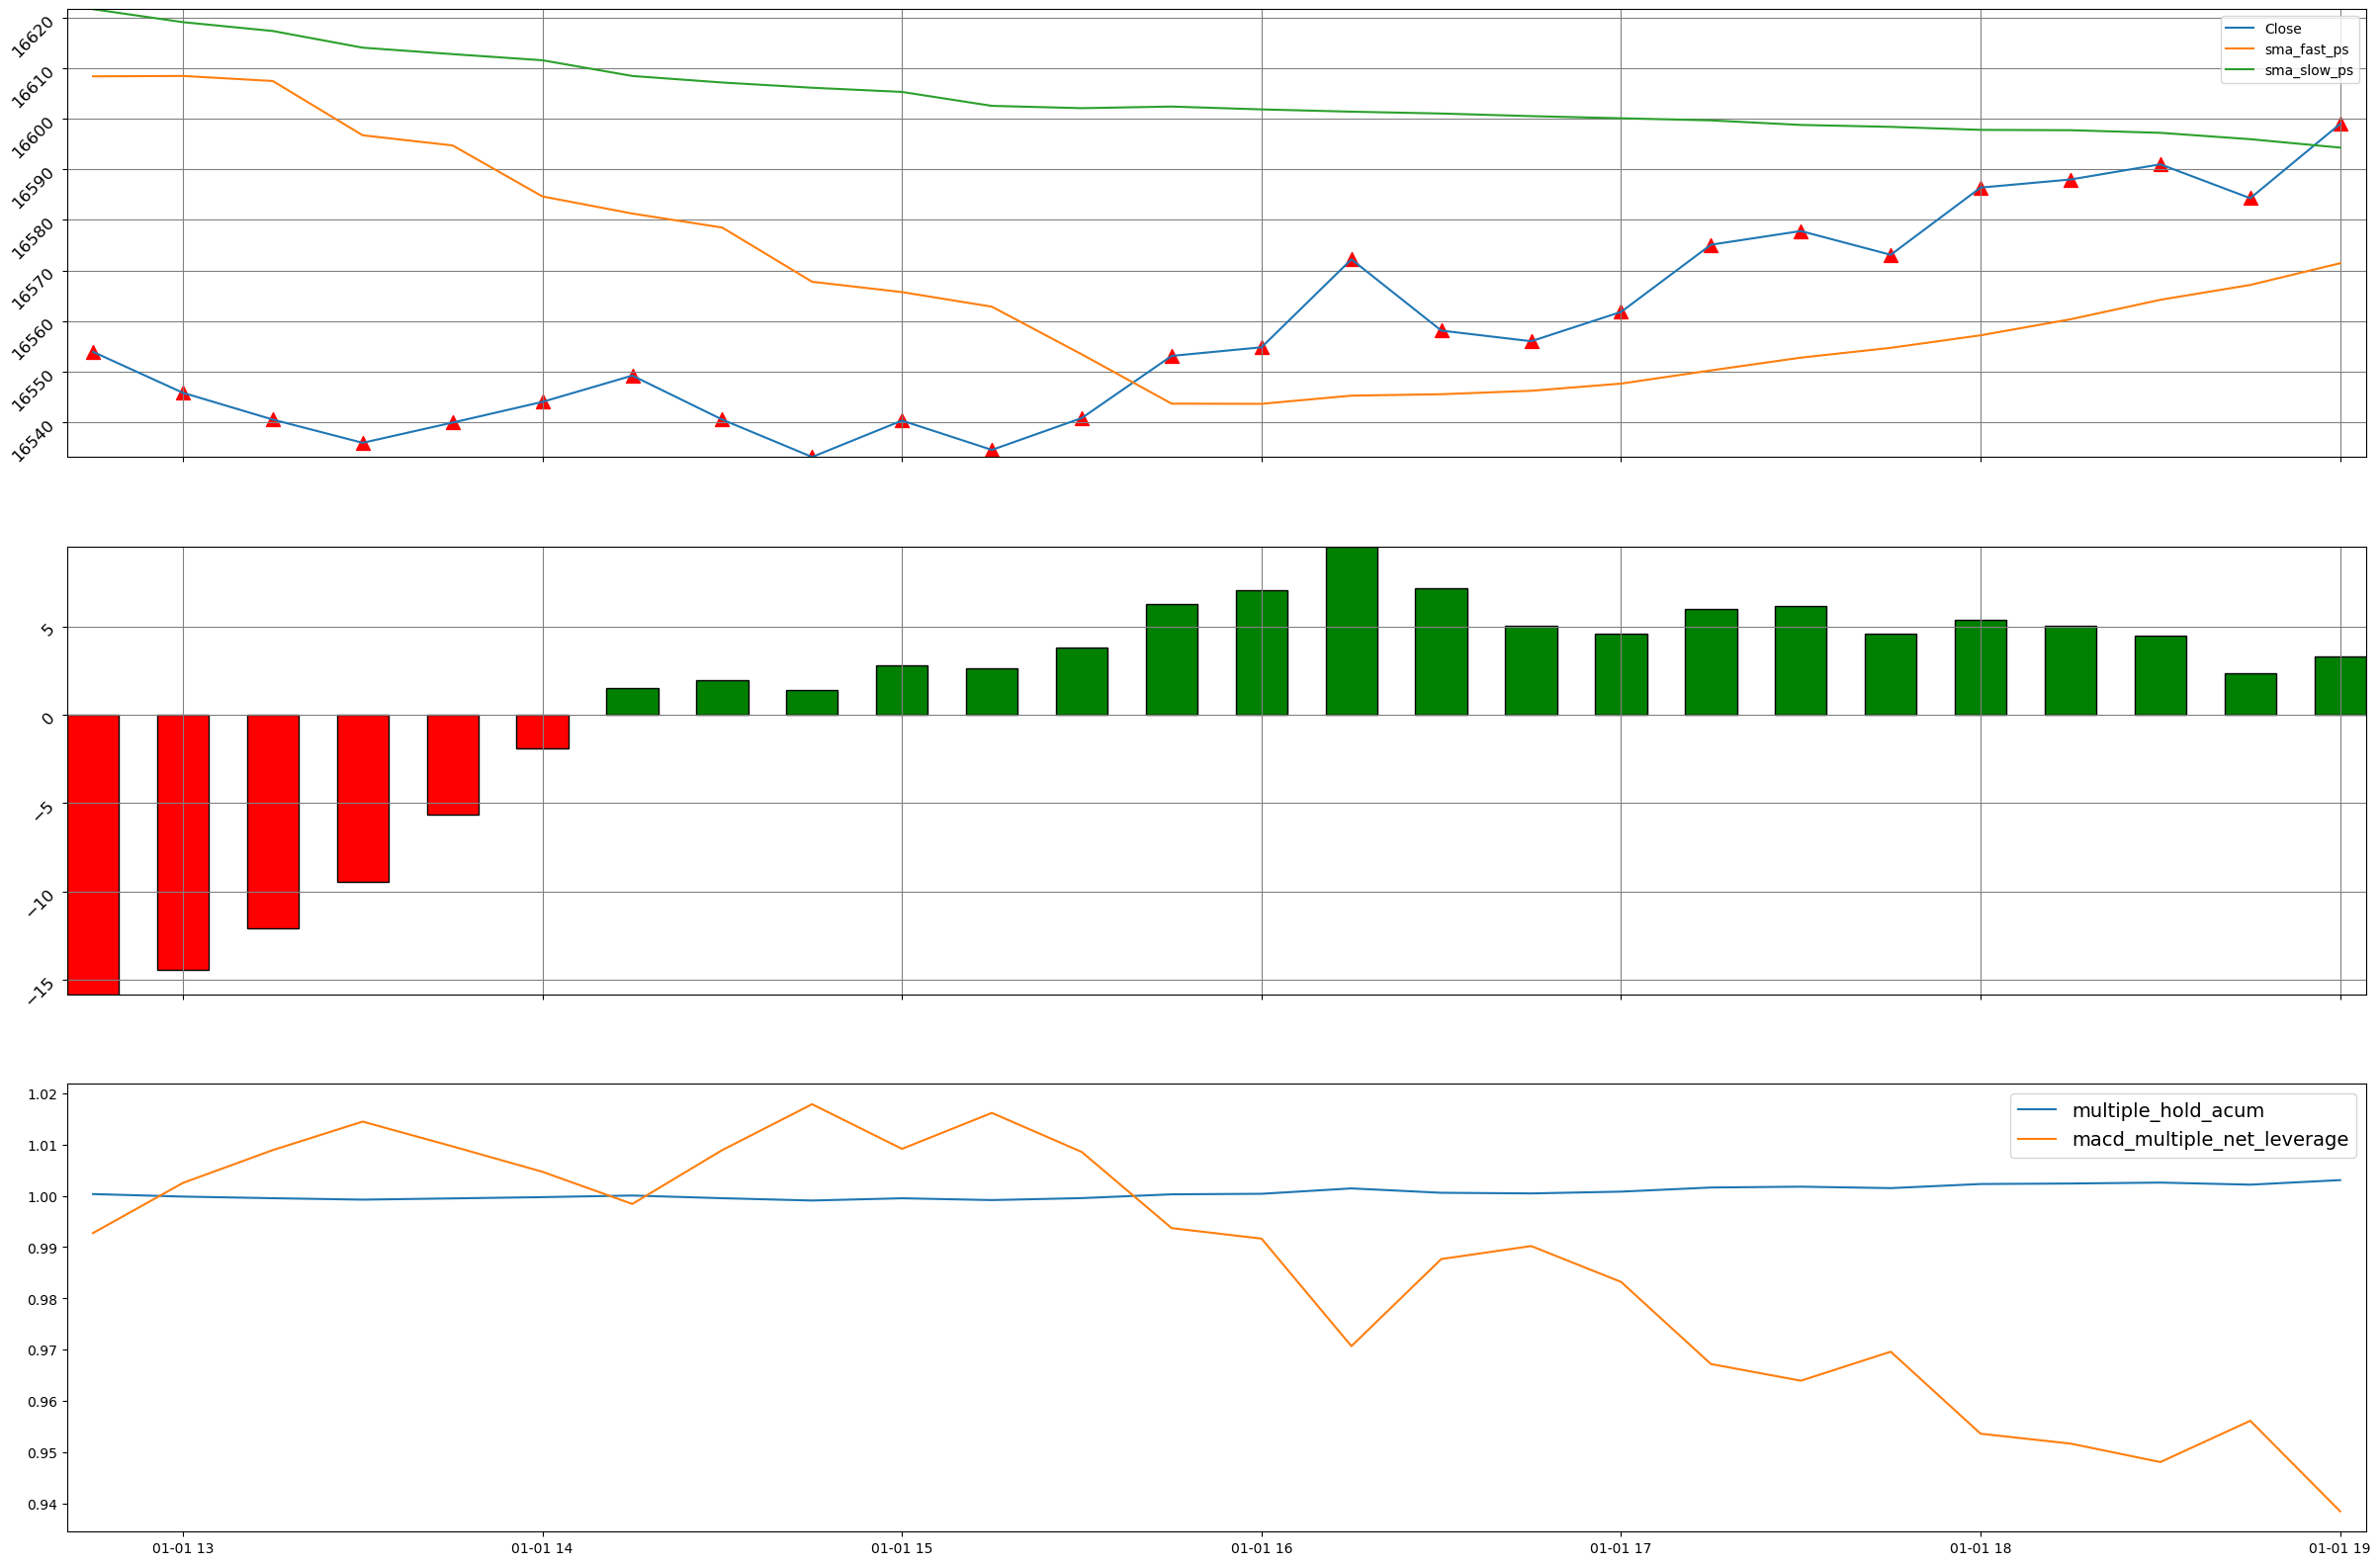

......................................................................................................................................

In [42]:
test_trader.plot_results(width_bars=0.006)

In [10]:
#test_trader.data['2022-12-31 18:00':]

In [14]:
#test_trader.data.loc[test_trader.trade_start_time_utc:]

In [11]:
#test_trader.client.futures_account_balance()

In [23]:
#test_trader.units